              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    198992
         1.0       0.03      0.77      0.06       105

    accuracy                           0.99    199097
   macro avg       0.52      0.88      0.53    199097
weighted avg       1.00      0.99      0.99    199097

ROC-AUC Score: 0.9681126448730172


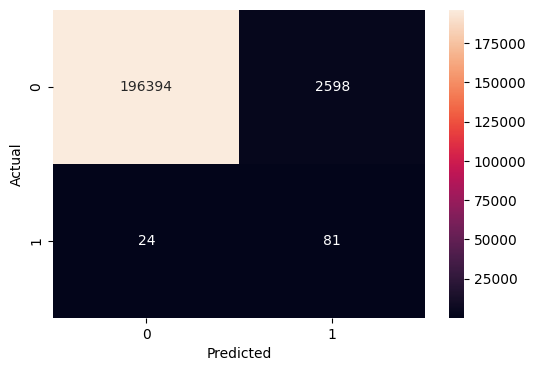

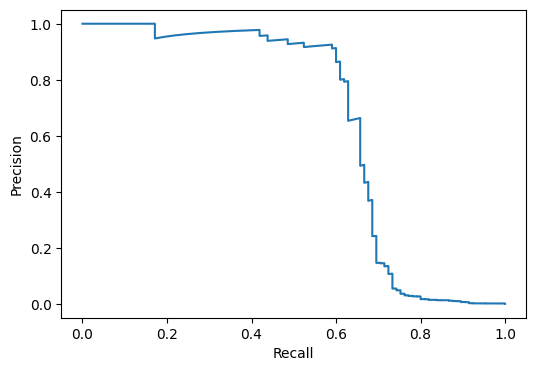

,0
type_PAYMENT,0.356838
balance_change_orig,0.301602
type_TRANSFER,0.103189
log_amount,0.084618
step,0.061015
balance_change_dest,0.042726
type_CASH_OUT,0.030182
type_DEBIT,0.019829


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


# Load Data
df = pd.read_csv("/content/Fraud.csv")


# Data Cleaning and Feature Engineering
df['log_amount'] = np.log1p(df['amount'])
df['balance_change_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']


# Feature Selection
features = [
    'step',
    'log_amount',
    'balance_change_orig',
    'balance_change_dest',
    'type'
]

X = df[features]
y = df['isFraud']

# Drop rows where 'y' is NaN
# Identify rows where 'isFraud' is NaN
nan_indices = y[y.isna()].index

# Drop these rows from both X and y
X = X.drop(nan_indices)
y = y.drop(nan_indices)

X = pd.get_dummies(X, columns=['type'], drop_first=True)


# Calibration and validation split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Model Training
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    eval_metric='auc'
)

model.fit(X_train, y_train)


# Model Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Precision Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).head(10)

1. Data cleaning including missing values, outliers and multi-collinearity

The dataset does not have any real missing values. Some destination balance fields are empty for merchant accounts, which is expected and not an error. Very large transaction amounts are important signs of fraud, so they are not removed. Instead, a log transformation is used to make them easier for the model to learn. Some balance-related columns are highly correlated, so balance change features are created to avoid redundancy.


2. Describe your fraud detection model in elaboration.

For fraud detection, an XGBoost Classifier is used. This model is well suited for large financial datasets and can efficiently handle millions of transactions. Fraud cases are very rare compared to normal transactions, so the model is designed to handle this class imbalance by assigning higher importance to fraudulent transactions.

XGBoost is capable of learning complex and non-linear relationships between transaction features such as amount, transaction type, and balance changes. This helps the model identify hidden fraud patterns that simple rule-based systems may miss.

The model is trained in a way that gives higher priority to recall, meaning it focuses on catching as many fraudulent transactions as possible, even if it slightly increases false alerts. This approach is preferred in financial systems because missing a fraud case can lead to high monetary loss.

3. How did you select variables to be included in the model?

Variables were chosen based on how fraud usually happens in real life. Features that show when the transaction happened, how much money was moved, changes in account balance, and the type of transaction were included. Transaction type is converted into numerical form using one encoding so the model can understand it.

4. Demonstrate the performance of the model using best set of tools

The model is evaluated using precision, recall, F1-score, ROC-AUC, confusion matrix, and precision-recall curve. These metrics are more meaningful than accuracy because fraud cases are very few compared to normal transactions.

5. What are the key factors that predict fraudulent customer?

The model shows that the type of transaction is one of the strongest indicators of fraud. Fraudulent activities mostly occur during TRANSFER and CASH_OUT transactions because these allow money to be moved or withdrawn quickly.
Another important factor is the transaction amount. Very large amounts are often used by fraudsters to drain accounts in a short time. The model also identifies sudden drops in the senders account balance as suspicious, since legitimate users rarely transfer their entire balance at once.
In addition, cases where the transferred amount does not correctly match the change in account balance strongly indicate fraudulent behavior. This usually happens when an account is taken over and manipulated by an attacker.

6. Do these factors make sense? If yes, how?

Yes, these factors make sense. Fraudsters usually try to move large amounts quickly and empty accounts. The pattern of transferring money and then cashing it out is common in fraud. Balance mismatches often mean that an account has been taken over by someone else.

7. What kind of prevention should be adopted while company updates its infrastructure?

The company should use the model to score transactions in real time, monitor accounts that make many transactions quickly, ask for extra verification for risky transactions, and closely watch suspicious transaction patterns.

8. Assuming these actions are implemented, how would you determine if they work?

The success of the system can be checked by seeing if fraud losses go down, more fraud cases are detected, fewer fraud cases are missed, and customer complaints decrease. Comparing results before and after using the model also helps measure improvement.